In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.patches smuggle Rectangle
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from sklearn.linear_model smuggle LinearRegression
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.stats import ttest_1samp, ttest_rel

from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

import os
import pickle

from helpers import group_pca, cross_validation, ridge_plot, conditions, condition_colors, basedir, datadir, figdir, scratch_dir, get_data, info_and_compressibility, plot_info_and_compressibility_scatter

Download and load data

In [3]:
data = get_data()

Load (computing and saving as needed) the reduced versions of the data using $k \in \{3, 4, 5, ..., 700\}$ components

In [ ]:
reduced_data = {'full': {}}
max_components = data['weights']['intact'][0].shape[1]

n_parts = 4
for i in range(n_parts):
    reduced_data[f'pt{i}'] = {}

for c in conditions:
    reduced_data['full'][c] = {}

    for i in range(n_parts):
        reduced_data[f'pt{i}'][c] = {}
    
    chunk_size = data['weights'][c][0].shape[0] // n_parts

    for n in tqdm(range(3, max_components + 1)):
        # full time range
        fname = os.path.join(scratch_dir, f'pca_full_{c}_{n}.pkl')
        reduced_data['full'][c][n], _ = group_pca(data['weights'][c], n_components=n, fname=fname)
        
        # chunked time range
        for i in range(n_parts):
            fname = os.path.join(scratch_dir, f'pca_pt{i + 1}_of_{n_parts}_{c}_{n}.pkl')
            chunk_start = i * chunk_size
            if i < n_parts - 1:                
                chunk_end = (i + 1) * chunk_size
            else:
                chunk_end = data['weights'][c][0].shape[0]
            
            next_chunk = [x.iloc[chunk_start:chunk_end] for x in data['weights'][c]]
            reduced_data[f'pt{i}'][c][n], _ = group_pca(next_chunk, n_components=n, fname=fname)
    
    data['weights'].pop(c)


100%|██████████| 698/698 [00:39<00:00, 17.52it/s]


In [ ]:
n_iter = 100

decoding_results = {'full': {}}
for i in range(n_parts):
    decoding_results[f'pt{i}'] = {}

for c in conditions:
    # full time range
    fname = os.path.join(scratch_dir, f'decoding_results_{n_iter}_full_{c}.pkl')
    decoding_results['full'][c] = cross_validation(reduced_data['full'][c], n_iter=n_iter, fname=fname)

    # chunked time range
    for i in range(n_parts):
        fname = os.path.join(scratch_dir, f'decoding_results_{n_iter}_pt{i + 1}_of_{n_parts}_{c}.pkl')
        decoding_results[f'pt{i}'][c] = cross_validation(reduced_data[f'pt{i}'][c], n_iter=n_iter, fname=fname)

In [ ]:
def plot_accuracy(x, fname=None):
    if not os.path.exists(figdir):
        os.makedirs(figdir)

    fig = plt.figure(figsize=(4, 3))
    ax = plt.gca()

    for c in conditions:
        sns.lineplot(x[c], x='Number of components', y='Relative decoding accuracy', label=c.capitalize(), color=condition_colors[c], legend=False)
    
    ax.set_xlabel('Number of components', fontsize=12)
    ax.set_ylabel('Relative decoding accuracy', fontsize=12)
    ax.set_ylim(-0.01, 0.35)
    ax.set_xlim(3, 700)
    ax.spines[['right', 'top']].set_visible(False)

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')

    return fig

# Figure 2A

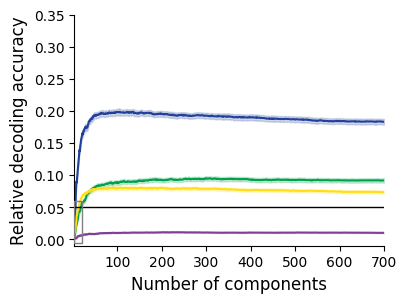

In [ ]:
fig = plot_accuracy(decoding_results['full']);
ax = plt.gca()

ax.plot([0, 700], [0.05, 0.05], '-', color='black', linewidth=1)
ax.add_patch(Rectangle((3, -0.005), 17, 0.065, fill=False, edgecolor='gray', linewidth=1, zorder=3))

fig.savefig(os.path.join(figdir, 'decoding_full.pdf'), bbox_inches='tight')


# Figure 2B

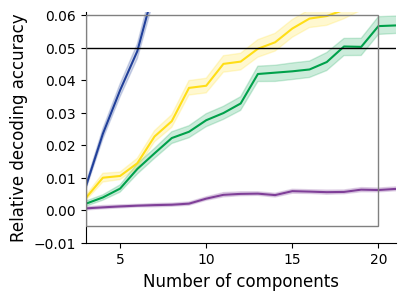

In [ ]:
fig = plot_accuracy(decoding_results['full']);
ax = plt.gca()

ax.plot([0, 700], [0.05, 0.05], '-', color='black', linewidth=1)
ax.add_patch(Rectangle((3, -0.005), 17, 0.065, fill=False, edgecolor='gray', linewidth=1, zorder=3))
ax.set_xlim(3, 21)
ax.set_ylim(-0.01, 0.061)

fig.savefig(os.path.join(figdir, 'decoding_full_zoomed.pdf'), bbox_inches='tight')

# Figure 2C

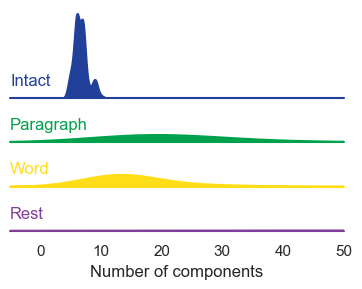

In [ ]:
ridge_plot(info_and_compressibility(decoding_results['full'], target=0.05), column='Number of components', xlim=[-5, 50], fname='n_components_dists_full');

# Figure 2D

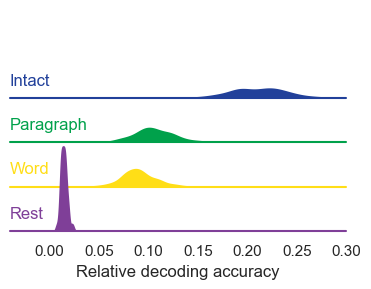

In [ ]:
ridge_plot(info_and_compressibility(decoding_results['full']), column='Relative decoding accuracy', xlim=[-0.04, 0.3], fname='decoding_accuracy_dists_full');

# Figure 2E

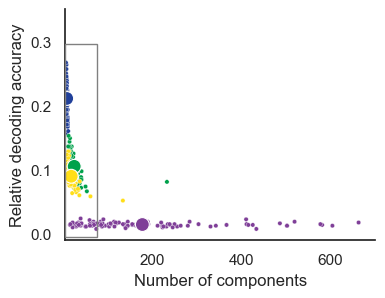

In [ ]:
fig = plot_info_and_compressibility_scatter(decoding_results['full']);
ax = plt.gca()
ax.add_patch(Rectangle((3, -0.005), 72, 0.3, fill=False, edgecolor='gray', linewidth=1, zorder=3))

fig.savefig(os.path.join(figdir, 'decoding_full_scatter.pdf'), bbox_inches='tight')


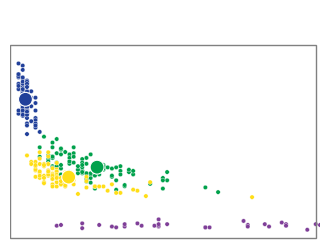

In [ ]:
ax.set_xlim(3, 76)
ax.set_axis_off()
fig.savefig(os.path.join(figdir, 'decoding_full_scatter_inset.pdf'), bbox_inches='tight')
fig


# Figure 3A

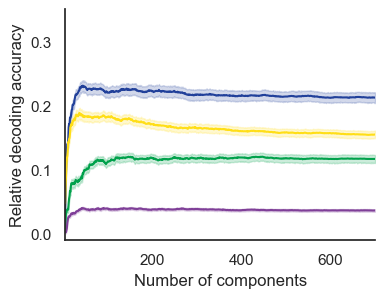

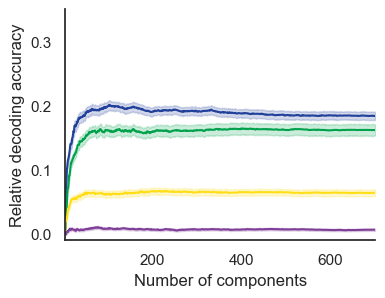

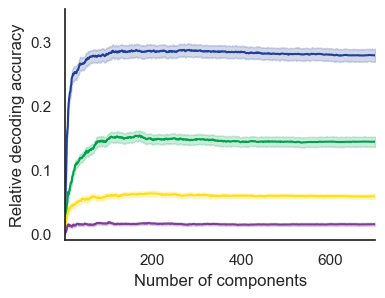

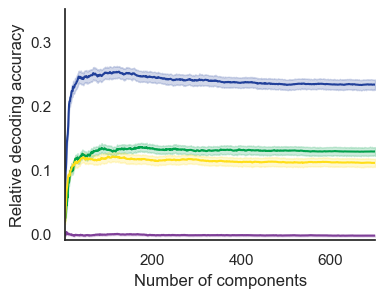

In [ ]:
for i in range(n_parts):
    plot_accuracy(decoding_results[f'pt{i}'], fname=f'decoding_pt{i + 1}_of_{n_parts}');

# Figure 3B

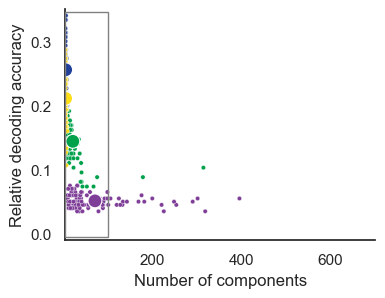

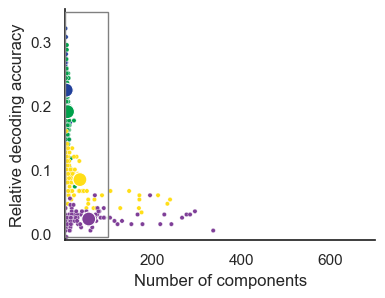

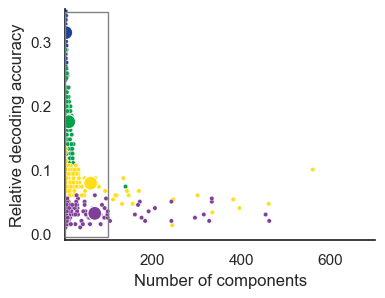

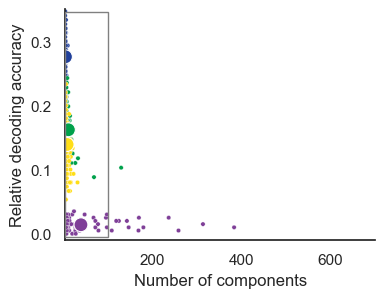

In [ ]:
for i in range(n_parts):
    fig = plot_info_and_compressibility_scatter(decoding_results[f'pt{i}']);
    ax = plt.gca()
    ax.add_patch(Rectangle((3, -0.005), 97, 0.35, fill=False, edgecolor='gray', linewidth=1, zorder=3))

    fig.savefig(os.path.join(figdir, f'decoding_pt{i + 1}_of_{n_parts}_scatter.pdf'), bbox_inches='tight')



# Fig 3B insets

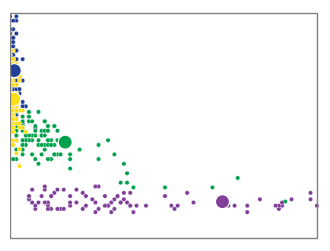

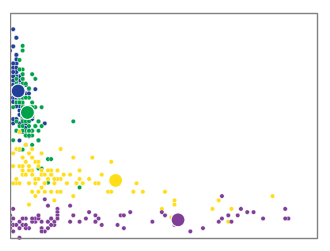

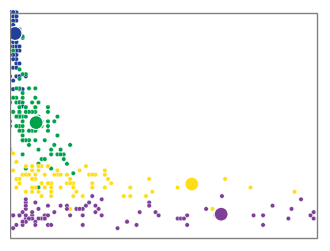

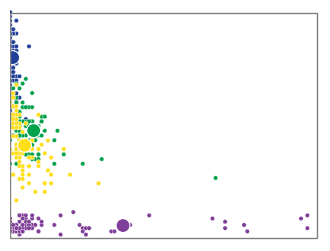

In [ ]:
for i in range(n_parts):
    fig = plot_info_and_compressibility_scatter(decoding_results[f'pt{i}']);
    ax = plt.gca()
    ax.add_patch(Rectangle((3, -0.005), 97, 0.35, fill=False, edgecolor='gray', linewidth=1, zorder=3))

    ax.set_xlim(3, 101)
    ax.set_axis_off()
    fig.savefig(os.path.join(figdir, f'decoding_pt{i + 1}_of_{n_parts}_scatter_inset.pdf'), bbox_inches='tight')
    fig


# Change analysis (Fig 3C)

In [ ]:
def accuracy_slopes(parts, fname=None):
    if fname is not None:
        if os.path.exists(fname):
            with open(fname, 'rb') as f:
                return pickle.load(f)

    components = np.unique(parts[0]['intact']['Number of components']).astype(int)
    iterations = np.unique(parts[0]['intact']['Iteration']).astype(int)
    df = []

    x = np.arange(len(parts)).reshape(-1, 1)

    for c in conditions:
        for i in tqdm(iterations):
            for n in components:
                y = []
                for p in parts:
                    y.append(p[c].query('Iteration == @i & `Number of components` == @n')['Relative decoding accuracy'].values.astype(float))
                y = np.array(y).reshape(-1, 1)

                # note: I'm not sure why the commented out code below doesn't work, whereas the above does...
                # y = pd.concat([p[c].query('Iteration == @i & `Number of components` == @n') for p in parts], axis=0).copy()['Relative decoding accuracy'].values.astype(float).reshape(-1, 1)

                regression = LinearRegression().fit(x, y)
                
                r = pd.Series(dtype=float)
                r['Number of components'] = n
                r['Slope'] = float(regression.coef_)
                r['Condition'] = c
                r['Iteration'] = i
                
                df.append(pd.DataFrame(r).T)
    
    df = pd.concat(df, ignore_index=True, axis=0)

    if fname is not None:
        with open(fname, 'wb') as f:
            pickle.dump(df, f)
    
    return df

In [ ]:
slopes = accuracy_slopes([decoding_results[f'pt{i}'] for i in range(n_parts)], fname=os.path.join(scratch_dir, f'decoding_slopes_{n_iter}.pkl'))

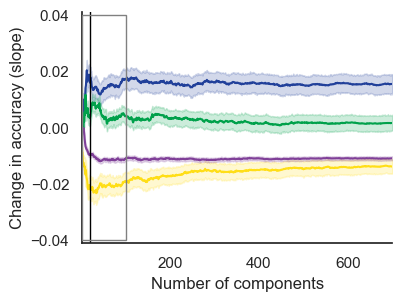

In [ ]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.lineplot(slopes, x='Number of components', y='Slope', hue='Condition', palette=[condition_colors[c] for c in conditions], legend=False)

ax.set_xlabel('Number of components', fontsize=12)
ax.set_ylabel('Change in accuracy (slope)', fontsize=12)
ax.plot([20, 20], [-0.05, 0.05], '-', color='black', linewidth=1)
ax.set_ylim(-0.041, 0.041)
ax.set_xlim(3, 700)
ax.spines[['right', 'top']].set_visible(False)

ax.add_patch(Rectangle((3, -0.04), 97, 0.08, fill=False, edgecolor='gray', linewidth=1, zorder=3))

fig.savefig(os.path.join(figdir, 'decoding_slopes.pdf'), bbox_inches='tight')

# Fig 3C inset

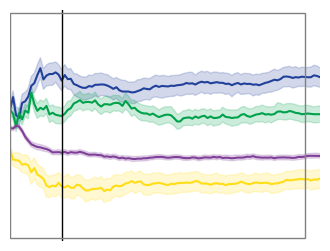

In [ ]:
ax.set_xlim([3, 105])
ax.set_axis_off()
fig.savefig(os.path.join(figdir, 'decoding_slopes_zoomed.pdf'), bbox_inches='tight')
fig

# Stats!

use t-tests to compare peak decoding accuracy across different conditions (across cross-validation runs):
- intact vs. paragraph, intact vs. word, intact vs. rest
- paragraph vs. word, paragraph vs. rest
- word vs. rest

In [ ]:
x = info_and_compressibility(decoding_results['full'])
x

,Number of components,Relative decoding accuracy,Condition,Iteration
0,9,0.181667,intact,0
1,7,0.236667,intact,1
2,7,0.188333,intact,2
3,6,0.243333,intact,3
4,9,0.166667,intact,4
...,...,...,...,...
395,279,0.012500,rest,95
396,139,0.008750,rest,96
397,154,0.015000,rest,97
398,59,0.012500,rest,98


In [ ]:
def pstring(pval):
    if pval < 0.001:
        return 'p < 0.001'
    else:
        return f'p = {pval:.3f}'

In [ ]:
for c1 in conditions:
    for c2 in conditions:
        if c1 == c2:
            continue

        results = ttest_rel(x.query('Condition == @c1')['Relative decoding accuracy'], x.query('Condition == @c2')['Relative decoding accuracy'])
        print(f"{c1} vs {c2}: $t({results.df}) = {results.statistic:0.3f}, {pstring(results.pvalue)})$")

intact vs paragraph: $t(99) = 35.205, p < 0.001)$
intact vs word: $t(99) = 43.172, p < 0.001)$
intact vs rest: $t(99) = 81.361, p < 0.001)$
paragraph vs intact: $t(99) = -35.205, p < 0.001)$
paragraph vs word: $t(99) = 6.243, p < 0.001)$
paragraph vs rest: $t(99) = 50.748, p < 0.001)$
word vs intact: $t(99) = -43.172, p < 0.001)$
word vs paragraph: $t(99) = -6.243, p < 0.001)$
word vs rest: $t(99) = 48.791, p < 0.001)$
rest vs intact: $t(99) = -81.361, p < 0.001)$
rest vs paragraph: $t(99) = -50.748, p < 0.001)$
rest vs word: $t(99) = -48.791, p < 0.001)$


for each "story" condition (intact, paragraph, and word), and for each cross-validation run, compute the number of components where each "decoding accuracy as a function of number of components" curve first exceeds the 5% decoding accuracy threshold marked in 2B

use t-tests to compare the numbers of components across conditions:
- intact vs. paragraph, intact vs. word
- paragraph vs. word

In [ ]:
for c1 in conditions:
    if c1 == 'rest':
        continue

    for c2 in conditions:
        if c2 == 'rest':
            continue
        elif c1 == c2:
            continue

        results = ttest_rel(x.query('Condition == @c1')['Number of components'], x.query('Condition == @c2')['Number of components'])
        print(f"{c1} vs {c2}: $t({results.df}) = {results.statistic:0.3f}, {pstring(results.pvalue)})$")

intact vs paragraph: $t(99) = -7.429, p < 0.001)$
intact vs word: $t(99) = -7.300, p < 0.001)$
paragraph vs intact: $t(99) = 7.429, p < 0.001)$
paragraph vs word: $t(99) = 2.459, p = 0.016)$
word vs intact: $t(99) = 7.300, p < 0.001)$
word vs paragraph: $t(99) = -2.459, p = 0.016)$


Based on Fig. 3C-- i.e., the "inflection" figure:

t-tests comparing the change in decoding accuracy for n = 20 components (rightmost part of Fig 3C) to 0:
- intact
- paragraph
- word
- rest

In [ ]:
slopes

,Number of components,Slope,Condition,Iteration
0,3.0,0.004,intact,0
1,4.0,-0.019333,intact,0
2,5.0,-0.014,intact,0
3,6.0,-0.004667,intact,0
4,7.0,0.01,intact,0
...,...,...,...,...
279195,696.0,-0.006,rest,99
279196,697.0,-0.006,rest,99
279197,698.0,-0.006,rest,99
279198,699.0,-0.006,rest,99


In [ ]:
for c in conditions:
    results = ttest_1samp(slopes.query('Condition == @c & `Number of components` == 20')['Slope'].astype(float), 0)
    print(f"{c}: $t({results.df}) = {results.statistic:0.3f}, {pstring(results.pvalue)})$")

intact: $t(99) = 7.915, p < 0.001)$
paragraph: $t(99) = 2.354, p = 0.021)$
word: $t(99) = -10.747, p < 0.001)$
rest: $t(99) = -22.081, p < 0.001)$
